<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_Weights_weightchangesMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split

import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

In [3]:
# shape of the data matrix
data.shape

(20000, 785)

In [4]:
# extract labels (numbers IDs) and remove from data
labels = data[:, 0]
data = data[:, 1:]

print(labels.shape)
print(data.shape)

(20000,)
(20000, 784)


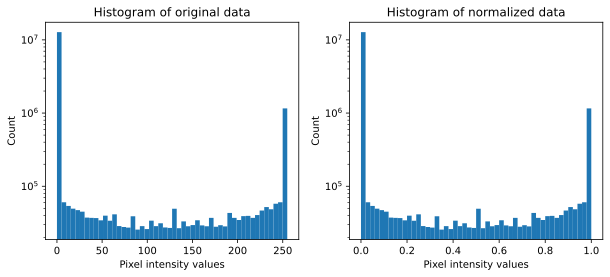

In [5]:
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(data.flatten(), 50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title("Histogram of original data")
ax[0].set_yscale('log')

ax[1].hist(dataNorm.flatten(), 50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
ax[1].set_yscale('log')

plt.show()

## Create train/test groups using dataloader

In [6]:
# step 1: convert to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long() # long = int64

# step 2: use scikit learn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=.1)

# step 3: convert into pyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# step 4: translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [7]:
# check all variables in workspace
%whos

Variable           Type             Data/Info
---------------------------------------------
DataLoader         type             <class 'torch.utils.data.dataloader.DataLoader'>
F                  module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset      type             <class 'torch.utils.data.dataset.TensorDataset'>
ax                 ndarray          2: 2 elems, type `object`, 16 bytes
batchsize          int              32
data               ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataNorm           ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT              Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
display            module           <module 'IPython.display'<...>ages/IPython/display.py'>
fig                Figure           Figure(720x288)
labels             ndarray          20000: 20000 elems, type `float64`, 1

## Create the DL model

In [8]:
# create a class for the model

def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            ## input layer
            self.input = nn.Linear(784, 64)

            ## hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            ## output layer
            self.output = nn.Linear(32, 10)
        
        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            
            return self.output(x)

        
    net = mnistNet()

    # loss function 
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [10]:
def function2trainTheModel(net, lossfun, optimizer):

    # number of epochs
    numepochs = 60

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # initialize weight change matrices
    weightChange = np.zeros((numepochs, 4))
    weightConds = np.zeros((numepochs, 4))

    # loop over epochs
    for epochi in range(numepochs):

        preW = []
        for p in net.named_parameters():
            if 'weight' in p[0]:
                preW.append(copy.deepcopy(p[1].data.numpy()))

        # loop over training data batches
        net.train()
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y 
            matchesNumeric = matches.float()
            accuracyPct = 100*torch.mean(matchesNumeric) 
            batchAcc.append(accuracyPct) 

        # end of batch loop

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        net.eval()
        # test accuracy
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        # compare the following really lon gline of code the training accuracy lines
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()))

        # finally,m get the post-learing state of the weights
        for (i, p) in enumerate(net.named_parameters()):
            if 'weight' in p[0]:

                # condition number
                weightConds[epochi, int(i/2)] = np.linalg.cond(p[1].data)

                # Frobenius norm  of the weight change from pre-learning
                weightChange[epochi, int(i/2)] = np.linalg.norm(preW[int(i/2)] - p[1].data.numpy(), ord='fro')

    # end epochs
    
    # function output
    return trainAcc, testAcc, losses, net, weightChange, weightConds, preW

## Run the model and show the results!

In [11]:
# create the network
net, lossfun, optimizer = createTheMNISTNet()

# train the model
trainAcc, testAcc, losses, net, weightChange, weightConds, preW = function2trainTheModel(net, lossfun, optimizer)

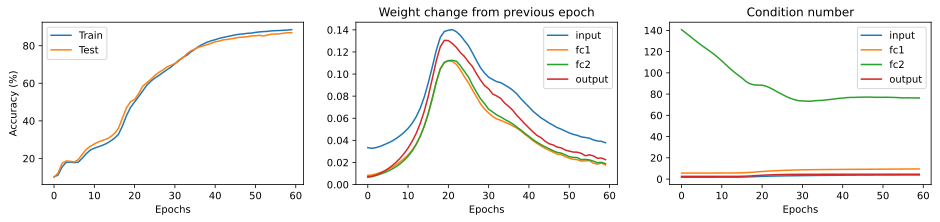

In [13]:
# show the results

# get a lsit of layers names
layername = []
for (i, p) in enumerate(net.named_parameters()):
    if 'weight' in p[0]:
        layername.append(p[0][:-7])

# set up the plot
fig, ax = plt.subplots(1, 3, figsize=(16, 3))

# accuray
ax[0].plot(trainAcc)
ax[0].plot(testAcc)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy (%)')
ax[0].legend(['Train', 'Test'])

# weight changes
ax[1].plot(weightChange)
ax[1].set_xlabel('Epochs')
ax[1].set_title('Weight change from previous epoch')
ax[1].legend(layername)

# weight condition numbers
ax[2].plot(weightConds)
ax[2].set_xlabel('Epochs')
ax[2].set_title('Condition number')
ax[2].legend(layername)
# ax[2].set_ylim([0, 20])
plt.show()

In [14]:
weightConds

array([[  1.72693288,   5.63411665, 140.73065186,   2.56407452],
       [  1.72629726,   5.63390541, 137.68296814,   2.55955362],
       [  1.72565591,   5.63428354, 134.6865387 ,   2.5553205 ],
       [  1.72506964,   5.6355896 , 131.70170593,   2.55128908],
       [  1.72464097,   5.6376543 , 128.68089294,   2.54750514],
       [  1.72444594,   5.64043427, 125.85699463,   2.54391575],
       [  1.72462273,   5.64423561, 123.21009827,   2.54041624],
       [  1.72527277,   5.64949942, 120.47870636,   2.53681016],
       [  1.72644627,   5.65642405, 117.73146057,   2.53316379],
       [  1.72831035,   5.66594887, 114.56445312,   2.52956152],
       [  1.73097563,   5.67925453, 111.21104431,   2.52657533],
       [  1.73470879,   5.69828224, 107.68764496,   2.52518654],
       [  1.73998392,   5.72538471, 104.11434174,   2.52793574],
       [  1.74806547,   5.76524878, 100.97005463,   2.53842425],
       [  1.76239753,   5.82584429,  97.98100281,   2.56526303],
       [  1.83305252,   5

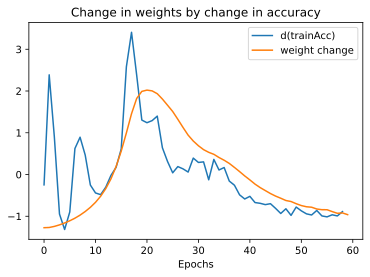

In [15]:
# final inspection: check the derivative of accuracy against the weight change
from scipy.stats import zscore # normalize for scaling offsets

plt.plot(zscore(np.diff(trainAcc)), label='d(trainAcc)')
plt.plot(zscore(np.mean(weightChange, axis=1)), label='weight change')
plt.legend()
plt.title('Change in weights by change in accuracy')
plt.xlabel('Epochs')
plt.show()